In [58]:
# 参考http://www.rdkit.org/docs/GettingStartedInPython.html
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

# 分子指纹生成

* 初始化

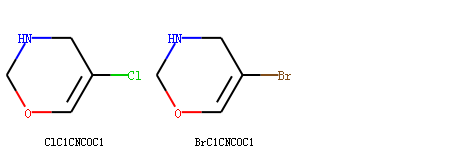

In [17]:
# 初始化rdkit mol对象m1和m2，并查看
m1 = Chem.MolFromSmiles('ClC1=COCNC1')
m2 = Chem.MolFromSmiles('BrC1=COCNC1')
Draw.MolsToGridImage([m1, m2], subImgSize=(150, 150), legends=['ClC1CNCOC1', 'BrC1CNCOC1'])

* 以SparseBitVects方式生成ECFPs指纹，需要传入mol和radius

In [18]:
fp1 = AllChem.GetMorganFingerprint(m1, 2)
fp2 = AllChem.GetMorganFingerprint(m2, 2)
DataStructs.DiceSimilarity(fp1, fp2)

0.7

* 以ExplicitBitVects方式生成ECFPs指纹，需要传入mol，radius和长度nBits

In [19]:
fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2, nBits=1024)
fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2, nBits=1024)
DataStructs.DiceSimilarity(fp1, fp2)

0.6842105263157895

* 通过设置useFeatures=True生成FCFPs <br /> 
可以看到ffp1和ffp2完全一致，即Cl和Br在特征上被归为一类

In [20]:
ffp1 = AllChem.GetMorganFingerprint(m1, 2, useFeatures=True)
ffp2 = AllChem.GetMorganFingerprint(m2, 2, useFeatures=True)
DataStructs.DiceSimilarity(ffp1, ffp2)

1.0

In [21]:
ffp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2, useFeatures=True)
ffp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2, useFeatures=True)
DataStructs.DiceSimilarity(ffp1, ffp2)

1.0

# 分子指纹提取

* 通过向参数bitInfo传入字典，可以获取所有非空指纹信息 <br /> 
字典info键表示位的索引，值为原子索引、半径构成的元组，出现多个元组时，表示子结构出现了多次<br />
键为2968968094的值中含有多个元组，表示原子索引为4,6，半径为0的子结构相同，都记录在这一位上

In [24]:
info = {}
fp_explain = AllChem.GetMorganFingerprint(m1, 2, bitInfo=info)
info

{39328034: ((1, 1),),
 211414882: ((5, 2),),
 362715007: ((6, 1),),
 397705891: ((4, 1),),
 718785834: ((1, 2),),
 1016841875: ((0, 0),),
 1078999752: ((3, 1),),
 1289643292: ((5, 1),),
 2132511834: ((5, 0),),
 2626911012: ((4, 2),),
 2968968094: ((4, 0), (6, 0)),
 3145053355: ((2, 1),),
 3189457552: ((3, 0),),
 3217380708: ((1, 0),),
 3218693969: ((2, 0),),
 3452535345: ((0, 1),),
 3916672621: ((6, 2),),
 4196496269: ((2, 2),),
 4217154750: ((3, 2),)}

## 方法一
* 以提取出211414882的结构为例，首先提取m1中，半径为2，第5个原子的结构 <br />
submol接收提取出的子结构 <br />
amap用于接收原子索引的映射关系，键为原始分子中的原子索引，值为子结构中的原子索引<br />
env是被提取出的键的索引

In [25]:
amap = {}
env = Chem.FindAtomEnvironmentOfRadiusN(m1, 2, 5)
submol=Chem.PathToSubmol(m1, env, atomMap=amap)
print(amap)
print(list(env))

{1: 4, 3: 0, 4: 1, 5: 2, 6: 3}
[4, 5, 3, 6]


* 用SMILES表示该子结构

In [26]:
Chem.MolToSmiles(submol)

'CCNCO'

* 以第5个原子为中心，用SMILES表示该子结构，可以看出是氮原子

In [28]:
Chem.MolToSmiles(submol, rootedAtAtom=amap[5], canonical=False)

'N(CO)CC'

## 方法二
* 遍历env中的所有键，获取键连接的所有原子，保存在atoms中 <br />
通过给定分子，及要提取的原子信息、键信息，获取子结构

In [29]:
atoms=set()
for bidx in env: 
    atoms.add(m1.GetBondWithIdx(bidx).GetBeginAtomIdx())
    atoms.add(m1.GetBondWithIdx(bidx).GetEndAtomIdx())
Chem.MolFragmentToSmiles(m1, atomsToUse=list(atoms), bondsToUse=env, rootedAtAtom=5)

'N(CC)CO'

# 分子指纹可视化

* 绘制211414882代表的子结构

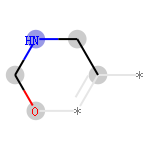

In [68]:
Draw.DrawMorganBit(m1, 211414882, info)

* 在ECFPs中的颜色的含义：<br />
蓝色：表示中心原子<br />
黄色：表示带有芳香性质的原子<br />
灰色：表示在脂肪环中的原子

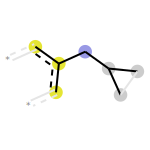

In [70]:
mol = Chem.MolFromSmiles('c1ccccc1CC1CC1')
bi = {}
fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, bitInfo=bi)
Draw.DrawMorganBit(mol, 872, bi, useSVG=True)

* 展示RDKit的分子指纹<br />
黄色表示带有芳香性质的原子

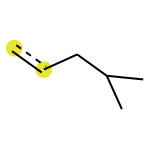

In [73]:
rdkinfo = {}
rdkfp = Chem.RDKFingerprint(mol, maxPath=5, bitInfo=rdkinfo)
Draw.DrawRDKitBit(mol, list(rdkinfo.keys())[0], rdkinfo)